# 2019320016 차주한

### Preprocess data using leammatizer

In [1]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import TreebankWordTokenizer

nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("treebank")

tb_tokenizer = TreebankWordTokenizer()
stop_words = stopwords.words("english")
lemmatizer = WordNetLemmatizer()

def tokenizer(text):
    tokens = tb_tokenizer.tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    return tokens


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hanchaa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hanchaa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hanchaa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package treebank to
[nltk_data]     C:\Users\hanchaa\AppData\Roaming\nltk_data...
[nltk_data]   Package treebank is already up-to-date!


### Load dataset and split into train & validation

In [2]:
import torch
from torchtext.legacy import data
from torchtext.legacy.data import TabularDataset

mail_field = data.Field(sequential=True, use_vocab=True, tokenize=tb_tokenizer.tokenize, lower=True, batch_first=True, fix_length=500)
label_field = data.Field(sequential=False, use_vocab=False, batch_first=False, is_target=True)
id_field = data.Field(sequential=False, use_vocab=False, batch_first=False, is_target=True)

loaded_data = TabularDataset(path="./data/train.csv",
                                 format="csv",
                                 fields=[("id" , id_field), ("label", label_field), ("mail", mail_field)],
                                 skip_header=True)

train_data, val_data = loaded_data.split(split_ratio=0.8, stratified=True)

print("train data: ", len(train_data))
print(train_data.fields)
print("validation data: ", len(val_data))
print(val_data.fields)

train data:  2896
{'id': <torchtext.legacy.data.field.Field object at 0x0000022CB4B81B80>, 'label': <torchtext.legacy.data.field.Field object at 0x0000022CB14BCB20>, 'mail': <torchtext.legacy.data.field.Field object at 0x0000022CB4B81BB0>}
validation data:  724
{'id': <torchtext.legacy.data.field.Field object at 0x0000022CB4B81B80>, 'label': <torchtext.legacy.data.field.Field object at 0x0000022CB14BCB20>, 'mail': <torchtext.legacy.data.field.Field object at 0x0000022CB4B81BB0>}


### Build vocabulary dictionary

In [5]:
from torchtext.vocab import GloVe

mail_field.build_vocab(train_data, vectors=GloVe(name="6B", dim=200), min_freq=3)
print("size of vocab: ", len(mail_field.vocab))
print("pretrained embedding vectors: ", mail_field.vocab.vectors.shape)
print(mail_field.vocab.stoi)

size of vocab:  10348
pretrained embedding vectors:  torch.Size([10348, 200])
defaultdict(<bound method Vocab._default_unk_index of <torchtext.legacy.vocab.Vocab object at 0x0000022CC05AB700>>, {'<unk>': 0, '<pad>': 1, '-': 2, '.': 3, '/': 4, ',': 5, ':': 6, 'the': 7, 'to': 8, 'ect': 9, '@': 10, 'and': 11, 'for': 12, 'of': 13, 'a': 14, "'": 15, 'you': 16, 'subject': 17, 'in': 18, 'hou': 19, '?': 20, 'this': 21, 'on': 22, 'enron': 23, 'is': 24, '=': 25, 'i': 26, ')': 27, '(': 28, 'be': 29, ';': 30, 'that': 31, 'we': 32, 'will': 33, '2000': 34, 'com': 35, 'from': 36, 'have': 37, 'your': 38, 'with': 39, 's': 40, 'at': 41, 'are': 42, '!': 43, 'it': 44, 'as': 45, '3': 46, 'if': 47, 'or': 48, 'not': 49, 'please': 50, 'gas': 51, '_': 52, 'by': 53, '``': 54, '$': 55, 'deal': 56, '1': 57, '2': 58, '#': 59, 'meter': 60, 'me': 61, 'am': 62, 'd': 63, '>': 64, 'cc': 65, '00': 66, '000': 67, 'hpl': 68, 'our': 69, '10': 70, 'pm': 71, 'can': 72, 'e': 73, 'any': 74, 're': 75, 'all': 76, 'corp': 77, '20

### Make data loader

In [6]:
from torchtext.legacy.data import Iterator

batch_size = 256
train_loader = Iterator(dataset=train_data, batch_size=batch_size, device="cuda")
val_loader = Iterator(dataset=val_data, batch_size=len(val_data), device="cuda", shuffle=False)

### Make recurrent net model

In [7]:
import torch.nn as nn

class MyModel(nn.Module):
    def __init__(self, n_layers, hidden_size, dropout):
        super(MyModel, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(mail_field.vocab.vectors, freeze=True, padding_idx=1)
        self.rnn = nn.GRU(num_layers=n_layers,input_size=mail_field.vocab.vectors.shape[1] ,hidden_size=hidden_size, batch_first=True)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout)
        self.linear = nn.Linear(hidden_size ,1)

    def forward(self, x):
        embedded = self.embedding(x)
        h, _ = self.rnn(embedded)
        h_t = h[:, -1, :]
        activation = self.relu(h_t)
        dropped = self.dropout(activation)
        logit = self.linear(dropped)
        return logit.squeeze()

### Train & evaluate function

In [8]:
def train(model, loss_fn, optimizer, loader):
    model.train()
    for batch in loader:
        x, y = batch.mail, batch.label
        optimizer.zero_grad()

        logit = model(x)
        loss = loss_fn(logit, y.float())
        loss.backward()

        optimizer.step()

def evaluate(model, loss_fn, loader):
    model.eval()
    total_loss, corrects = 0, 0

    for batch in loader:
        x,y = batch.mail, batch.label

        logit = model(x)
        loss = loss_fn(logit, y.float())
        total_loss += loss.item()

        predicted = (logit > 0) * 1
        corrects += (predicted == y).sum()

    size = len(loader.dataset)
    avg_loss = total_loss / size
    avg_accuracy = corrects / size

    return avg_loss, avg_accuracy

In [9]:
best_val_acc = 0
best_model_train_acc = 0
best_model = None
best_model_history = None
best_model_hyperparameter = {}

In [10]:
import copy

def train_model_with_hyperparameter(lr, dropout, reg, hidden_size):
    global best_val_acc
    global best_model_train_acc
    global best_model
    global best_model_history
    global best_model_hyperparameter

    train_history = []
    val_history = []

    model = MyModel(n_layers=1, hidden_size=hidden_size, dropout=dropout).to("cuda")
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=reg)
    loss_fn = torch.nn.BCEWithLogitsLoss(reduction="sum").to("cuda")

    for e in range(30):
        train(model, loss_fn, optimizer, train_loader)
        train_loss, train_accuracy = evaluate(model, loss_fn, train_loader)
        val_loss, val_accuracy = evaluate(model, loss_fn, val_loader)

        train_history.append(train_accuracy.cpu().item())
        val_history.append(val_accuracy.cpu().item())

        print("[Epoch: %2d] train loss: %5.4f | train accuracy: %5.4f | val loss: %5.4f | val accuracy: %5.4f" % (e + 1, train_loss, train_accuracy, val_loss, val_accuracy))

        if  val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            best_model_train_acc = train_accuracy
            best_model = copy.deepcopy(model)
            best_model_history = (train_history, val_history)
            best_model_hyperparameter = {"lr": lr, "dropout": dropout, "reg": reg, "hidden_size": hidden_size}

### Train model with random hyperparameters

In [11]:
import numpy as np

for i in range(5):
    lr = np.random.uniform(6e-3, 8e-3)
    dropout = np.random.uniform(0.5, 0.8)
    reg = np.random.uniform(8.5e-4, 9.5e-4)
    hidden_size = np.random.randint(8, 9)

    print("lr: %e / dropout: %f / reg: %e / hidden size: %d" %(lr, dropout, reg, 2 ** hidden_size))
    train_model_with_hyperparameter(lr, dropout, reg, 2 ** hidden_size)
    print()

print("Best model validation accuracy: ", best_val_acc)
print("Best model train accuracy: ", best_model_train_acc)
print("Best model hyper parameters")
print("lr %e: " % (best_model_hyperparameter["lr"]))
print("dropout: ", best_model_hyperparameter["dropout"])
print("reg %e: " % (best_model_hyperparameter["reg"]))
print("hidden size:", best_model_hyperparameter["hidden_size"])

lr: 6.789576e-03 / dropout: 0.797878 / reg: 9.232762e-04 / hidden size: 256
[Epoch:  1] train loss: 0.5955 | train accuracy: 0.7151 | val loss: 0.5922 | val accuracy: 0.7155
[Epoch:  2] train loss: 0.5860 | train accuracy: 0.7262 | val loss: 0.5908 | val accuracy: 0.7196
[Epoch:  3] train loss: 0.5783 | train accuracy: 0.7362 | val loss: 0.5845 | val accuracy: 0.7224
[Epoch:  4] train loss: 0.5640 | train accuracy: 0.7390 | val loss: 0.5717 | val accuracy: 0.7320
[Epoch:  5] train loss: 0.4469 | train accuracy: 0.7493 | val loss: 0.4547 | val accuracy: 0.7293
[Epoch:  6] train loss: 0.3163 | train accuracy: 0.8916 | val loss: 0.3143 | val accuracy: 0.8881
[Epoch:  7] train loss: 0.5281 | train accuracy: 0.7151 | val loss: 0.5314 | val accuracy: 0.7155
[Epoch:  8] train loss: 0.3517 | train accuracy: 0.8015 | val loss: 0.3538 | val accuracy: 0.7956
[Epoch:  9] train loss: 0.2042 | train accuracy: 0.9171 | val loss: 0.1966 | val accuracy: 0.9240
[Epoch: 10] train loss: 0.1505 | train acc

### Visualize GRU train history

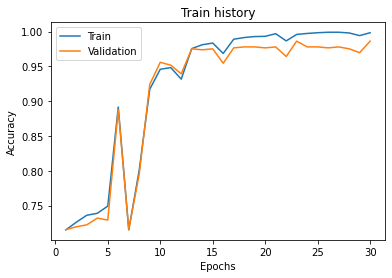

In [12]:
from matplotlib import pyplot as plt
epochs = list(range(1, 31))

plt.plot(epochs, best_model_history[0])
plt.plot(epochs, best_model_history[1])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train history")
plt.legend(["Train", "Validation"])
plt.show()

In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay

def print_performance(y, y_predict):
    ConfusionMatrixDisplay.from_predictions(y, y_predict)
    plt.show()

    print("accuracy: ", accuracy_score(y, y_predict))
    print("precision: ", precision_score(y, y_predict))
    print("recall: ", recall_score(y, y_predict))
    print("f1: ", f1_score(y, y_predict))

### Performance of GRU model on train set

C:\Users\hanchaa\anaconda3\envs\COSE362\lib\site-packages\torch\nn\modules\rnn.py:849: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ..\aten\src\ATen\native\cudnn\RNN.cpp:925.)
  result = _VF.gru(input, hx, self._flat_weights, self.bias, self.num_layers,


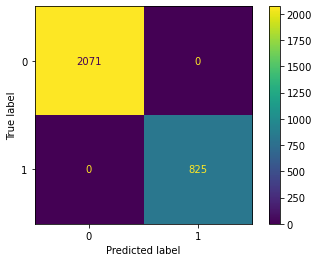

accuracy:  1.0
precision:  1.0
recall:  1.0
f1:  1.0


In [14]:
y_train = torch.LongTensor([])
gru_train_result = torch.LongTensor([])

for batch in train_loader:
    x = batch.mail
    y = batch.label.cpu()

    logit = best_model(x)
    gru_result = ((logit >= 0) * 1).cpu()

    y_train = torch.concat([y_train, y])
    gru_train_result = torch.concat([gru_train_result, y])

print_performance(y_train, gru_train_result)

### Performance of GRU model on validation set

C:\Users\hanchaa\anaconda3\envs\COSE362\lib\site-packages\torch\nn\modules\rnn.py:849: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ..\aten\src\ATen\native\cudnn\RNN.cpp:925.)
  result = _VF.gru(input, hx, self._flat_weights, self.bias, self.num_layers,


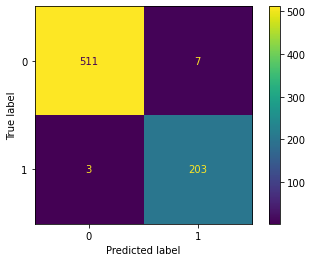

accuracy:  0.9861878453038674
precision:  0.9666666666666667
recall:  0.9854368932038835
f1:  0.9759615384615385


In [47]:
for batch in val_loader:
    x = batch.mail
    y = batch.label.cpu().numpy()
    ids = batch.id.cpu().numpy()

    logit = best_model(x)
    gru_val_result = ((logit >= 0) * 1).cpu().numpy()

print_performance(y, gru_val_result)

### Misclassified email ids

In [50]:
def print_misclassified(result):
    print(ids[np.where(y != result)])

print_misclassified(gru_val_result)

[1391  572 1224 2336 1816 1908 2308 3464 1387 2984]


### Prepare datas for naive bayse

In [16]:
import numpy as np

X_train = []
y_train = []
X_val = []
y_val = []

for i in train_data:
    X_train.append(" ".join(i.mail))
    y_train.append(i.label)

for i in val_data:
    X_val.append(" ".join(i.mail))
    y_val.append(i.label)

X_train = np.array(X_train)
y_train = np.array(y_train).astype(int)
X_val = np.array(X_val)
y_val = np.array(y_val).astype(int)

print(vars(train_data[0]))
print("label: ", y_train[0], ", mail: ", X_train[0])

print(vars(val_data[0]))
print("label: ", y_val[0], ", mail: ", X_val[0])

{'id': '1631', 'label': '1', 'mail': ['subject', ':', 'quality', 'meds', 'at', 'discount', 'prices', 'muscle', 'relaxants', ',', 'allergies', ',', 'sleeping', 'disorders', ',', 'men', "'", 's', 'health', ',', 'pain', 'relief', ',', 'wt', 'loss', ',', 'depression', '-', 'anxiety', 'and', 'quit', 'smoking', 'drugs', 'at', 'low', 'pricing', 'are', 'available', 'through', 'our', 'internet', 'store', '.', 'a', 'wide', 'selection', 'for', 'your', 'medical', 'needs', 'deal', 'on', 'meds', 'with', 'rx', 'at', 'no', 'charrge', 'to', 'you', 'appointment', 'far', 'away', 'if', 'only', 'you', 'are', 'with', 'us', 'just', 'try', 'this', 'and', 'pay', 'less', 'on', 'meds', 'i', 'find', 'a', 'lot', 'of', 'things', 'in', 'site', 'with', 'no', 'need', 'to', 'pay', ',', 'like', 'consultation', 'or', 'prescription', '.', 'your', 'guys', 'get', 'one', 'more', 'loyal', 'customer', 'from', 'now', 'on', '.', '-', '-', 'your', 'loyal', 'episode', 'of', 'american', 'history', '.', 'we', "'", 've', 'created', '

### Make word of bag and transform to feature vector

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(tokenizer=tokenizer, min_df=3)
X_train_vectorized = vectorizer.fit_transform(X_train)
X_val_vectorized = vectorizer.transform(X_val)

print("subject dtm shape: " + str(X_train_vectorized.shape))

subject dtm shape: (2896, 8305)


### Train Naive Bayse

In [29]:
from sklearn.naive_bayes import MultinomialNB

best_nb_model = None
best_nb_val_acc = 0
train_acc_history = []
val_acc_history = []
alphas = [1, 0.75, 0.5, 0.25, 0.1, 0.075, 0.05, 0.025, 0.01, 0.0075, 0.005, 0.0025, 0.001, 0.00075, 0.0005]

for alpha in alphas:
    NB_model = MultinomialNB(alpha=alpha)
    NB_model.fit(X_train_vectorized, y_train)

    train_acc = accuracy_score(y_train, NB_model.predict(X_train_vectorized))
    val_acc = accuracy_score(y_val, NB_model.predict(X_val_vectorized))

    train_acc_history.append(train_acc)
    val_acc_history.append(val_acc)

    print("alpha: %f / train acc: %f / val acc: %f" % (alpha, train_acc, val_acc))

    if val_acc > best_nb_val_acc:
        best_nb_val_acc = val_acc
        best_nb_model = copy.deepcopy(NB_model)

alpha: 1.000000 / train acc: 0.972030 / val acc: 0.959945
alpha: 0.750000 / train acc: 0.975483 / val acc: 0.965470
alpha: 0.500000 / train acc: 0.977210 / val acc: 0.972376
alpha: 0.250000 / train acc: 0.973757 / val acc: 0.970994
alpha: 0.100000 / train acc: 0.974448 / val acc: 0.975138
alpha: 0.075000 / train acc: 0.975138 / val acc: 0.973757
alpha: 0.050000 / train acc: 0.975829 / val acc: 0.975138
alpha: 0.025000 / train acc: 0.977901 / val acc: 0.975138
alpha: 0.010000 / train acc: 0.982044 / val acc: 0.977901
alpha: 0.007500 / train acc: 0.982390 / val acc: 0.979282
alpha: 0.005000 / train acc: 0.982390 / val acc: 0.979282
alpha: 0.002500 / train acc: 0.984116 / val acc: 0.982044
alpha: 0.001000 / train acc: 0.985152 / val acc: 0.980663
alpha: 0.000750 / train acc: 0.985497 / val acc: 0.980663
alpha: 0.000500 / train acc: 0.985497 / val acc: 0.980663


### Plot NB accuracy change upon hyperparameter

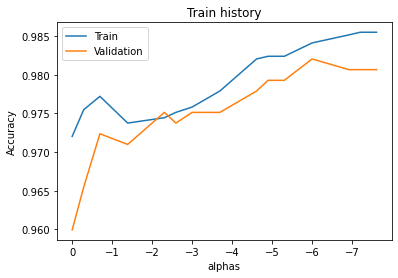

In [30]:
from matplotlib import pyplot as plt

plt.plot(np.log(alphas), train_acc_history)
plt.plot(np.log(alphas), val_acc_history)
plt.gca().invert_xaxis()
plt.xlabel("alphas")
plt.ylabel("Accuracy")
plt.title("Train history")
plt.legend(["Train", "Validation"])
plt.show()

### Performance of the best NB model on train set

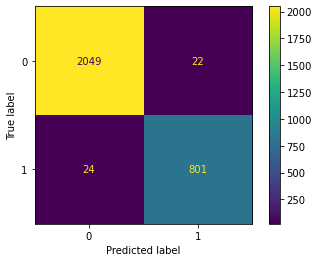

accuracy:  0.9841160220994475
precision:  0.9732685297691372
recall:  0.9709090909090909
f1:  0.9720873786407768


In [31]:
nb_train_result = best_nb_model.predict(X_train_vectorized)
print_performance(y_train, nb_train_result)

### Performance of the best NB model on validation set

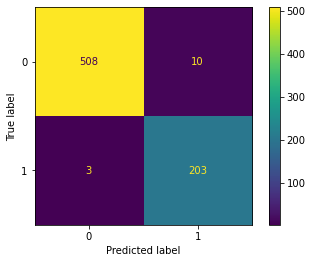

accuracy:  0.9820441988950276
precision:  0.9530516431924883
recall:  0.9854368932038835
f1:  0.9689737470167064


In [32]:
nb_val_result = best_nb_model.predict(X_val_vectorized)
print_performance(y_val, nb_val_result)

### Misclassified email ids

In [51]:
print_misclassified(nb_val_result)

[2965  572 2675 3360 2536 3349 2954 2308 1387 1857 2984 3572 3502]


### Train SVM

In [37]:
from sklearn.svm import SVC

best_svm_model = None
best_svm_val_acc = 0
train_acc_history = []
val_acc_history = []
cs = [0.1, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3]

for c in cs:
    SVM_model = SVC(kernel="linear", C=c, probability=True)
    SVM_model.fit(X_train_vectorized, y_train)

    train_acc = accuracy_score(y_train, SVM_model.predict(X_train_vectorized))
    val_acc = accuracy_score(y_val, SVM_model.predict(X_val_vectorized))

    train_acc_history.append(train_acc)
    val_acc_history.append(val_acc)

    print("c: %f / train acc: %f / val acc: %f" % (c, train_acc, val_acc))

    if val_acc > best_svm_val_acc:
        best_svm_val_acc = val_acc
        best_svm_model = copy.deepcopy(SVM_model)

c: 0.100000 / train acc: 0.975483 / val acc: 0.962707
c: 0.250000 / train acc: 0.987224 / val acc: 0.979282
c: 0.500000 / train acc: 0.995166 / val acc: 0.982044
c: 0.750000 / train acc: 0.997583 / val acc: 0.983425
c: 1.000000 / train acc: 0.998273 / val acc: 0.982044
c: 1.250000 / train acc: 0.998619 / val acc: 0.982044
c: 1.500000 / train acc: 0.998964 / val acc: 0.979282
c: 1.750000 / train acc: 0.998964 / val acc: 0.980663
c: 2.000000 / train acc: 0.999309 / val acc: 0.979282
c: 2.250000 / train acc: 0.999309 / val acc: 0.979282
c: 2.500000 / train acc: 0.999309 / val acc: 0.979282
c: 2.750000 / train acc: 0.999309 / val acc: 0.979282
c: 3.000000 / train acc: 0.999309 / val acc: 0.979282


### Plot SVM accuracy change upon hyperparameter

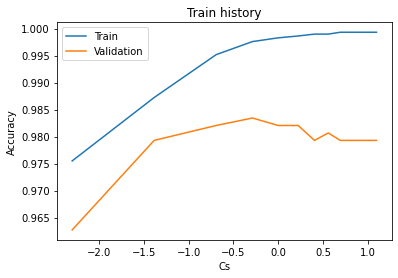

In [38]:
from matplotlib import pyplot as plt

plt.plot(np.log(cs), train_acc_history)
plt.plot(np.log(cs), val_acc_history)
plt.xlabel("Cs")
plt.ylabel("Accuracy")
plt.title("Train history")
plt.legend(["Train", "Validation"])
plt.show()

### Performance of the best SVM model on train set

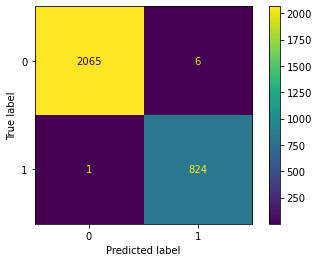

accuracy:  0.9975828729281768
precision:  0.9927710843373494
recall:  0.9987878787878788
f1:  0.9957703927492447


In [39]:
svm_train_result = best_svm_model.predict(X_train_vectorized)
print_performance(y_train, svm_train_result)

### Performance of the best SVM model on validation set

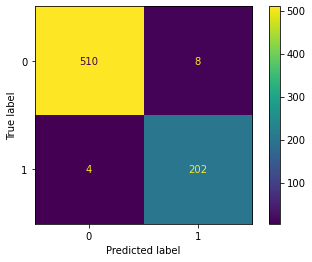

accuracy:  0.9834254143646409
precision:  0.9619047619047619
recall:  0.9805825242718447
f1:  0.9711538461538461


In [40]:
svm_val_result = best_svm_model.predict(X_val_vectorized)

print_performance(y_val, svm_val_result)

### Misclassified email ids

In [52]:
print_misclassified(svm_val_result)

[3036 3431  572 1490  838 3360 1140 1387 1857 2984 1299 3572]


### Performance of ensemble model on train data

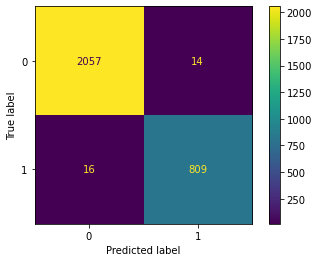

accuracy:  0.9896408839779005
precision:  0.982989064398542
recall:  0.9806060606060606
f1:  0.9817961165048544


In [42]:
ensembled_train_result = ((gru_train_result + nb_train_result + svm_train_result) >= 2) * 1
print_performance(y_train, ensembled_train_result)

### Performance of ensemble model on validation data

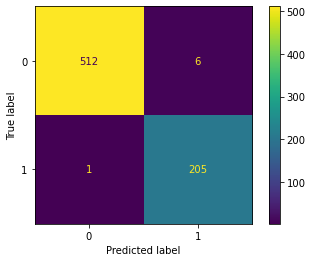

accuracy:  0.9903314917127072
precision:  0.9715639810426541
recall:  0.9951456310679612
f1:  0.9832134292565947


In [43]:
ensembled_val_result = ((gru_val_result + nb_val_result + svm_val_result) >= 2) * 1
print_performance(y_val, ensembled_val_result)

### Misclassified email ids

In [53]:
print_misclassified(ensembled_val_result)

[ 572 3360 2308 1387 1857 2984 3572]


### Predict on test data

In [45]:
test_data = TabularDataset(path="./data/test.csv",
                                 format="csv",
                                 fields=[("id" , id_field), ("mail", mail_field)],
                                 skip_header=True)

test_loader = Iterator(dataset=test_data, batch_size=len(test_data), device="cuda", shuffle=False)

best_model.eval()

for batch in test_loader:
    x = batch.mail
    id = batch.id

    print(id)

    logit = best_model(x)
    gru_test_result = ((logit >= 0) * 1).cpu().numpy()

X_test = []

for i in test_data:
    X_test.append(" ".join(i.mail))

X_test_vectorized = vectorizer.transform(X_test)
nb_test_result = best_nb_model.predict(X_test_vectorized)
svm_test_result = best_svm_model.predict(X_test_vectorized)

ensembled_predicted = ((gru_test_result + nb_test_result + svm_test_result) >= 2) * 1

print(ensembled_predicted)

tensor([   0,    1,    2,  ..., 1548, 1549, 1550], device='cuda:0')


C:\Users\hanchaa\anaconda3\envs\COSE362\lib\site-packages\torch\nn\modules\rnn.py:849: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ..\aten\src\ATen\native\cudnn\RNN.cpp:925.)
  result = _VF.gru(input, hx, self._flat_weights, self.bias, self.num_layers,


[0 0 0 ... 1 0 0]


In [46]:
import csv

f = open("result.csv", "w", newline="")
wr = csv.writer(f)
wr.writerow(["id", "label"])

id = 0
for i in ensembled_predicted:
    wr.writerow([id, i])
    id += 1

f.close()